In [17]:
# Import Libraries
import cassio
import os
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
import numpy as np
from langchain_openai.embeddings import OpenAIEmbeddings

In [37]:
# Set environment variables
load_dotenv()
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [19]:
# Initialize cassio
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

In [20]:
# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [21]:
# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [22]:
# Split in chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size= 500, chunk_overlap= 50)
docs_splits = text_splitter.split_documents(docs_list)

In [23]:
# embeddings = HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings")
embeddings = OpenAIEmbeddings()

In [24]:
astra_vector_store = Cassandra(
    embedding=embeddings,
    table_name="research_table",
    session=None,
    keyspace=None
)

In [26]:
astra_vector_store.add_documents(docs_splits)
print("Inserted %i headlines." % len(docs_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 91 headlines.


In [27]:
retriever=astra_vector_store.as_retriever()

In [28]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Document(id='537597493d3e439d8d2fa9720b3938d4', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

### LangGraph Workflow

In [53]:
from pydantic import BaseModel, Field
from IPython.display import display, Image
from langgraph.graph import StateGraph, START,END
from typing import Literal, TypedDict, List
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema import Document
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_groq import ChatGroq

In [42]:
# Define Graph State
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [54]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

In [55]:
llm=ChatGroq(model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

In [56]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

In [57]:
# Define chain
question_router = route_prompt | structured_llm_router

In [58]:
# Test question router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)

datasource='wiki_search'


In [59]:
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'


In [44]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [46]:
## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [66]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)
    print(wiki_results)

    return {"documents": wiki_results, "question": question}

In [49]:
# Routing

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [70]:
# Generate Answer
def generate_answer(state):
    """Getnerate appropriate answer by LLM using the documents as context"""
    documents = state.get("documents", None)
    question = state["question"]
    llm = ChatGroq(model_name= "Llama-3.2-3b-Preview")
    prompt =f"""
    You are very good in finding and summarzing answers from context.
    Your task is to find the answer of the following question from the following context and summerize the it in an appropriate manner.
    Context: {documents}
    Question: {question}
    """
    response = llm.invoke(prompt)
    return {"generation": response.content}

In [72]:
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("generate_answer", generate_answer)

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", "generate_answer")
workflow.add_edge( "wiki_search", "generate_answer")
workflow.add_edge("generate_answer", END)
# Compile
app = workflow.compile()

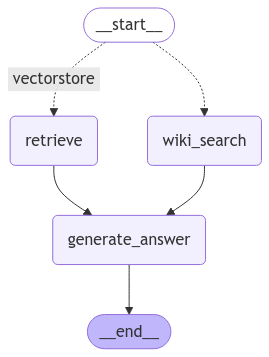

In [73]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [75]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
"Node 'generate_answer':"
'\n---\n'
('Based on the given context, the answer to the question "What is agent?" can '
 'be summarized as follows:\n'
 '\n'
 'An agent in the context of LLM (Large Language Model) powered autonomous '
 'systems refers to a machine that acts on behalf of a user to accomplish a '
 'specific task or set of tasks. The agent is equipped with a large language '
 'model as its core controller, which enables it to break down complex tasks '
 'into smaller, manageable subgoals, reflect on past actions, and refine them '
 'for future steps. The agent also has access to short-term and long-term '
 'memory, which allows it to learn from past experiences and retain '
 'information over extended periods. Furthermore, the agent can utilize '
 'external tools and APIs to gather additional information and solve complex '
 'problems.')


In [76]:
# Run
inputs = {
    "question": "Who is Elon Musk?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Who is Elon Musk?
page_content='Page: Errol Musk
Summary: Errol Graham Musk (born 1946) is a South African politician, engineer, consultant, father of Elon Musk, and businessman.'
"Node 'wiki_search':"
'\n---\n'
"Node 'generate_answer':"
'\n---\n'
("Based on the given context, here's a summary of the answer to the question "
 '"Who is Elon Musk?":\n'
 '\n'
 'Elon Musk is the son of Errol Graham Musk.')
